<a href="https://colab.research.google.com/github/ekttd/VAST-Challenge/blob/main/VAST_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Загрузка данных**

In [1]:
import pandas as pd

In [2]:
friday_url = "https://github.com/ekttd/VAST-Challenge/raw/main/MC2%202015%20Data/comm-data-Fri.csv"
df = pd.read_csv(friday_url)
df.head()

,Timestamp,from,to,location
0,2014-6-06 08:03:19,439105,1053224,Kiddie Land
1,2014-6-06 08:03:19,439105,1696241,Kiddie Land
2,2014-6-06 08:03:19,439105,580064,Kiddie Land
3,2014-6-06 08:03:19,439105,1464748,Kiddie Land
4,2014-6-06 08:03:47,1836139,1593258,Entry Corridor


# **Преобразование данных.**

---
Добавлены интервалы по 15 минут для визуалаизации


In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# вообще Timestamp и так был datetime, но почему-то
# без явного преобразования дальше не работает(

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
start_time = df['Timestamp'].iloc[0]

# сколько минут прошло от первой записи
minutes_from_start = (df['Timestamp'] - start_time).dt.total_seconds() // 60

# метка интервала - делим всю колонку на 15, получается номер интервала
df['quarter'] = (minutes_from_start // 15 + 1).astype(int)

df[5000:5010]

,Timestamp,from,to,location,quarter
5000,2014-06-06 08:26:01,864973,275317,Tundra Land,2
5001,2014-06-06 08:26:01,864973,1991646,Tundra Land,2
5002,2014-06-06 08:26:01,864973,636911,Tundra Land,2
5003,2014-06-06 08:26:01,864973,767374,Tundra Land,2
5004,2014-06-06 08:26:01,864973,1298361,Tundra Land,2
5005,2014-06-06 08:26:01,864973,1227574,Tundra Land,2
5006,2014-06-06 08:26:01,864973,1086555,Tundra Land,2
5007,2014-06-06 08:26:01,864973,1707585,Tundra Land,2
5008,2014-06-06 08:26:01,864973,376187,Tundra Land,2
5009,2014-06-06 08:26:01,864973,327024,Tundra Land,2


In [5]:
df['hour'] = df['Timestamp'].dt.hour
df['minute'] = df['Timestamp'].dt.minute
df = df.drop(columns=['Timestamp'])
df.head()

,from,to,location,quarter,hour,minute
0,439105,1053224,Kiddie Land,1,8,3
1,439105,1696241,Kiddie Land,1,8,3
2,439105,580064,Kiddie Land,1,8,3
3,439105,1464748,Kiddie Land,1,8,3
4,1836139,1593258,Entry Corridor,1,8,3


In [6]:
# количество записей в каждую четверть
quarters_intence = df['quarter'].value_counts().sort_index()
quarters_intence.head()

,count
quarter,
1,2564
2,4960
3,8117
4,12165
5,11651


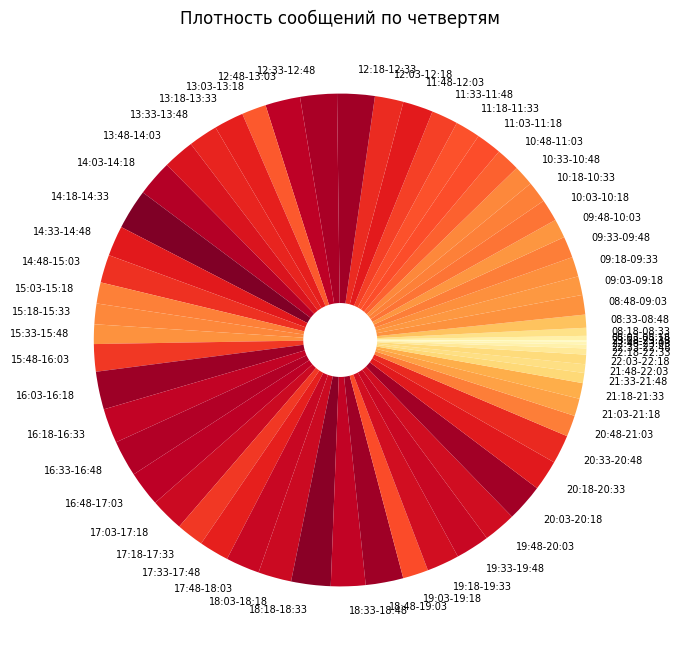

In [9]:
values = quarters_intence.values
intervals = quarters_intence.index

start_minutes = df.loc[0, 'hour'] * 60 + df.loc[0, 'minute']

labels = []
for i in intervals:
    start = start_minutes + (i - 1) * 15
    end = start + 15

    h1, m1 = divmod(start, 60)
    h2, m2 = divmod(end, 60)

    labels.append(f"{h1:02d}:{m1:02d}-{h2:02d}:{m2:02d}")

if values.max() == values.min():
    norm = np.zeros_like(values)
else:
    norm = (values - values.min()) / (values.max() - values.min())

colors = plt.cm.YlOrRd(norm)

plt.figure(figsize=(8,8))

plt.pie(
    values,
    labels=labels,
    colors=colors,
    wedgeprops=dict(width=0.85),
    textprops={'fontsize': 7}
)

plt.title("Плотность сообщений по четвертям")
plt.show()

In [10]:
# количество сообщений в каждой локации
location_counts = df.groupby('location').size().sort_values(ascending=False)
location_counts.head()

,0
location,
Wet Land,353319
Entry Corridor,191229
Tundra Land,172764
Coaster Alley,117934
Kiddie Land,113493
